In [1]:
import os

from io import StringIO
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import expit
from scipy.stats import norm, ttest_rel, pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler
import umap
import hdbscan

from itertools import product

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] = '14'

## Hyperparams

In [7]:
threads = 2
elites = 15
n_per_trial = threads * elites
exp_names = ['param']

In [8]:
results_dir = {e: sorted(os.listdir(e)) for e in exp_names}
num_trials = []
for k, v in results_dir.items():
    num_trials.append(len(v))
num_trials

[2]

In [9]:
palette = sns.cubehelix_palette(4)

## Load data

In [13]:
d = {'internal connection': [], 'type': [], 'cat': [], 'r': [], 'p': []}

x = np.vstack((np.arange(1, 201),) * 150 * threads).T
x = x.flatten()

for exp, trails in results_dir.items():
    for i in trails:        
        survivals = []
        n_syns = []
        i2es = []
        
        for j in range(threads):
            log = np.loadtxt(os.path.join(exp, i, 'log%d.tsv' % j),
                             dtype=np.float64)
            survival = log[:, 0].reshape(200, -1)
            n_syn = log[:, 1].reshape(200, -1)
            i2e = log[:, 2].reshape(200, -1)
            survivals.append(survival)
            n_syns.append(n_syn)
            i2es.append(i2e)
            
        survivals = np.hstack(survivals)
        n_syns = np.hstack(n_syns)
        i2es = np.hstack(i2es)
        
        for k, y in zip(('Survival Cost', 'Number of Synapses', 'I/E Ratio'), (survivals, n_syns, i2es)):
            y = y.flatten()
#             rp, pp = pearsonr(x, y)
            r, p = spearmanr(x, y)
            
        
            d['internal connection'].append(exp)
            d['type'].append(i[:-1])
#             d['noise'].append((float(i[-1]) * 2 - 1) / 10)
            d['cat'].append(k)
            d['r'].append(r)
            d['p'].append(p)
df_evostats = pd.DataFrame(d)        
#         print(survivals.shape, n_syns.shape, i2es.shape)

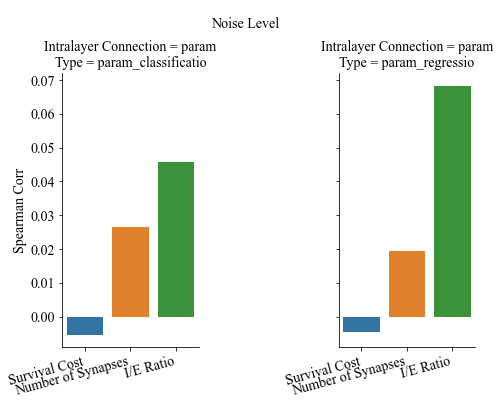

In [15]:
grid = sns.catplot('cat', 'r', row='internal connection', col='type', kind='bar', data=df_evostats, aspect=0.7, legend=False)
grid.set_axis_labels('', 'Spearman Corr')
grid.add_legend(bbox_to_anchor=(0.5, 1.05), ncol=4, title='Noise Level')
ax = grid.axes.flat[-1]
# ax.text(0.7, 0.1, '#', color='r', fontweight='bold')
# ax.text(2.25, 0.1, '#', color='r', fontweight='bold')
grid.set_titles('Intralayer Connection = {row_name}\nType = {col_name}')
grid.set_xticklabels(rotation=15, horizontalalignment='right')
# grid.fig.tight_layout()

# grid.savefig('images/spearman.pdf')

In [16]:
df_evostats[df_evostats['p'] > 0.001]

,internal connection,type,cat,r,p
0,param,param_classificatio,Survival Cost,-0.005334,0.191339
3,param,param_regressio,Survival Cost,-0.004714,0.248217


In [17]:
def read(id_):
    with open(id_ + 'g.tsv', 'r') as f:
        lines = f.readlines()
    genome_shared = pd.read_csv(StringIO(''.join(lines[:2])), delim_whitespace=True)
    genome_types = pd.read_csv(StringIO(''.join(lines[2:])), delim_whitespace=True)
        
    with open(id_ + 'r.tsv', 'r') as f:
        lines = f.readlines()
    
    i = 0
    connection_counts = trivial_counts = 0
    meta = re.compile(r'\d+')
    n = genome_shared.n_types[0]
    connections = np.zeros((n, n), dtype=np.object)
    while i < len(lines)-1:
        if lines[i][0] != '#':
            print(i, len(lines), lines[i])
            raise ValueError('Wrong information on the shape of the matrix')
        
        s, t, ns, nt = tuple(map(int, meta.findall(lines[i])))
        
        # print(s, ns, genome_types.n_cell.iloc[s], t, nt, genome_types.n_cell.iloc[t])
        assert ns == genome_types.n_cell.iloc[s] and nt == genome_types.n_cell.iloc[t]
        
        txt = StringIO(''.join(lines[i+1:i+1+ns]))
        connections[s, t] = np.loadtxt(txt, delimiter='\t', dtype=np.float64)
        
        connection_counts += 1
        if not connections[s, t].any():
            trivial_counts += 1
            
        i = i + 1 + ns
    
    return genome_shared, genome_types, connections, connection_counts, trivial_counts

In [19]:
results = []
for exp, trails in results_dir.items():
    for i in trails: 
        for tid in range(threads):
            for rid in range(elites):
                genome_shared, genome_types, connections, \
                connection_counts, trivial_counts \
                = read(os.path.join(exp, i, '%d_%d' % (tid, rid)))
                df = pd.DataFrame({'internal connection': [exp],
                                   'type': [i[:-1]],
#                                    'noise': [(float(i[-1]) * 2 - 1) / 10], 
                                   'genome_shared': [genome_shared], 
                                   'genome_types': [genome_types], 
                                   'connections': [connections], 
                                   'connection_counts': [connection_counts], 
                                   'trivial_counts': [trivial_counts]})
                results.append(df)
results = pd.concat(results, ignore_index=True)
results.head()

,internal connection,type,genome_shared,genome_types,connections,connection_counts,trivial_counts
0,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity ...,"[[0, [[0.8744 0.8597 0.8443 0.8282 0.8115 0.79...",25,0
1,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity p...,"[[0, [[0.8727 0.8544 0.835 0.8146 0.7935 0.77...",25,0
2,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity ...,"[[0, [[0.2772 0.2579 0.2378 0.2173 0.1...",1,0
3,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity p...,"[[0, [[0.8746 0.8603 0.8453 0.8297 0.8136 0.79...",25,0
4,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity ...,"[[0, [[0.873 0.8553 0.8366 0.817 0.7966 0.77...",25,0


In [71]:
%load_ext Cython

In [72]:
# %%cython
# import pandas as pd
# import numpy as np
# cimport numpy as np
# cimport cython
# cimport scipy.linalg.cython_blas as blas

# @cython.boundscheck(False)
# @cython.wraparound(False)
# @cython.initializedcheck(False)
# @cython.cdivision(True)
# cdef void laplacian(double[::1,:] lap, double[::1,:] adj, int[::1] r, int[::1] c, double[::1] e):
#     cdef int inc = 1, m = lap.shape[0], n = lap.shape[1]
#     cdef int i, j
#     cdef double w
#     for i in range(r.shape[0]):
#         for j in range(e.shape[0]): e[j] = 0.0
#         e[r[i]] = 1
#         e[c[i]] = -1
#         w = adj[r[i], c[i]]
#         blas.dger(&m, &n, &w, &e[0], &inc, &e[0], &inc, &lap[0, 0], &m)
        
def eigen(results):
    adjs = []
#     laps = []
    eigs = []
    
    for i, row in results.iterrows():
        cumsum = row.genome_types.n_cell.cumsum()
        total = cumsum.iloc[-1]
        
        # Adjacency matrix
        adj = np.zeros((total, total), dtype=np.float64)
        r = 0
        for i, ri in enumerate(cumsum):
            c = 0
            for j in range(row.genome_shared.n_types.values[0]):
                wij = row.connections[i, j]
                ci = row.genome_types.n_cell.iloc[j]
                if type(wij) is np.ndarray:
                    try:
                        adj[r:ri, c:c+ci] = wij
                    except:
                        adj[r:ri, c:c+ci] = wij[:,None]
                c += ci
            r = ri
    
#         # Laplacian matrix
#         lap = np.zeros(adj.shape, dtype=np.float64, order='F')
#         r, c = np.where(adj != 0)
#         r = np.asfortranarray(r, dtype=np.int32)
#         c = np.asfortranarray(c, dtype=np.int32)
#         e = np.zeros(total, dtype=np.float64, order='F')
#         laplacian(lap, np.asfortranarray(adj), r, c, e)

#         lap = np.ascontiguousarray(lap)

        # Spectrum
        vals = np.real(np.linalg.eigvals(adj))
        i = np.argsort(vals)
        vals = vals[i]
        vals = vals[::-1]

        adjs.append(adj)
#         laps.append(lap)
        eigs.append(vals)
    
    results['adjacency'] = pd.Series(adjs, index=results.index)
#     results['laplacian'] = pd.Series(laps, index=results.index)
    results['eigenvals'] = pd.Series(eigs, index=results.index)

In [73]:
eigen(results)
results.head()

,internal connection,type,genome_shared,genome_types,connections,connection_counts,trivial_counts,adjacency,eigenvals
0,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity ...,"[[0, [[0.8744 0.8597 0.8443 0.8282 0.8115 0.79...",25,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[157.16743368686633, 12.324092590954203, 0.000..."
1,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity p...,"[[0, [[0.8727 0.8544 0.835 0.8146 0.7935 0.77...",25,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[20.614340350283854, 2.0717515463298755, 0.014..."
2,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity ...,"[[0, [[0.2772 0.2579 0.2378 0.2173 0.1...",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity p...,"[[0, [[0.8746 0.8603 0.8453 0.8297 0.8136 0.79...",25,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[6.257854492107508, 0.6458374457912446, 0.0973..."
4,param,param_classificatio,n_types ganglion_th test_loss n_synapses...,n_cell axon dendrite polarity ...,"[[0, [[0.873 0.8553 0.8366 0.817 0.7966 0.77...",25,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[161.06202511547963, 12.587187482701049, 0.000..."


## Structure

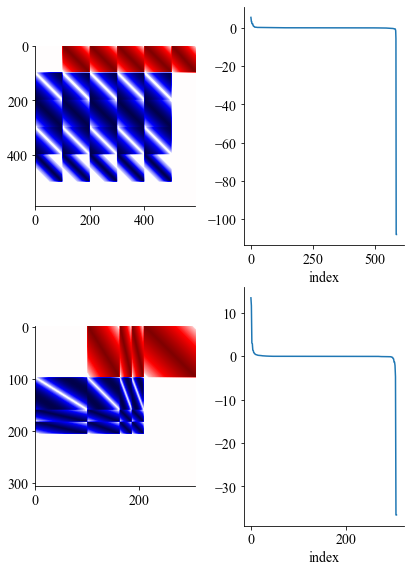

In [203]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(h=8, w=6)
fig.tight_layout()

k2 = 'cla2'

for i, j in enumerate((10, 20)):
    im = ax[i, 0].imshow(results.iloc[j].adjacency, cmap='seismic', vmin=-1, vmax=1)
    
    ax[i, 1].plot(results.iloc[j].eigenvals)
    ax[i, 1].set_xlabel('index')

# fig.savefig('images/eigen_example.pdf')

## Scores

<Figure size 576x576 with 0 Axes>

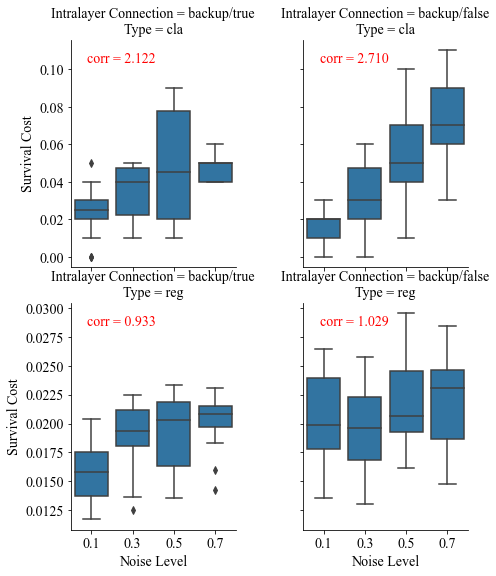

In [204]:
def plot(x, y, color, **kwargs):
    y = [yi.total_cost.values[0] for yi in y]
    ax = sns.boxplot(x, y, color=color, **kwargs)
    corr = np.correlate(x, y)[0]
    plt.text(0.1, 0.9, 'corr = %.3f' % corr, c='r', transform=ax.transAxes)
    
plt.figure(figsize=(8,8))
grid = sns.FacetGrid(results, col='internal connection', row='type', sharey='row', height=4, aspect=0.9)
grid.map(plot, 'noise', 'genome_shared')
grid.set_titles('Intralayer Connection = {col_name}\nType = {row_name}')
grid.set_axis_labels(x_var='Noise Level', y_var='Survival Cost')

# grid.savefig('images/score.pdf')

In [205]:
n_eig = [i.shape[0] for i in results.eigenvals]
spectra_pad = np.zeros((results.shape[0], max(n_eig)))

for i, row in results.iterrows():
    spectra_pad[i, :n_eig[i]] = row.eigenvals
scaled_spectra = StandardScaler().fit_transform(spectra_pad)
scaled_spectra.shape

(480, 631)

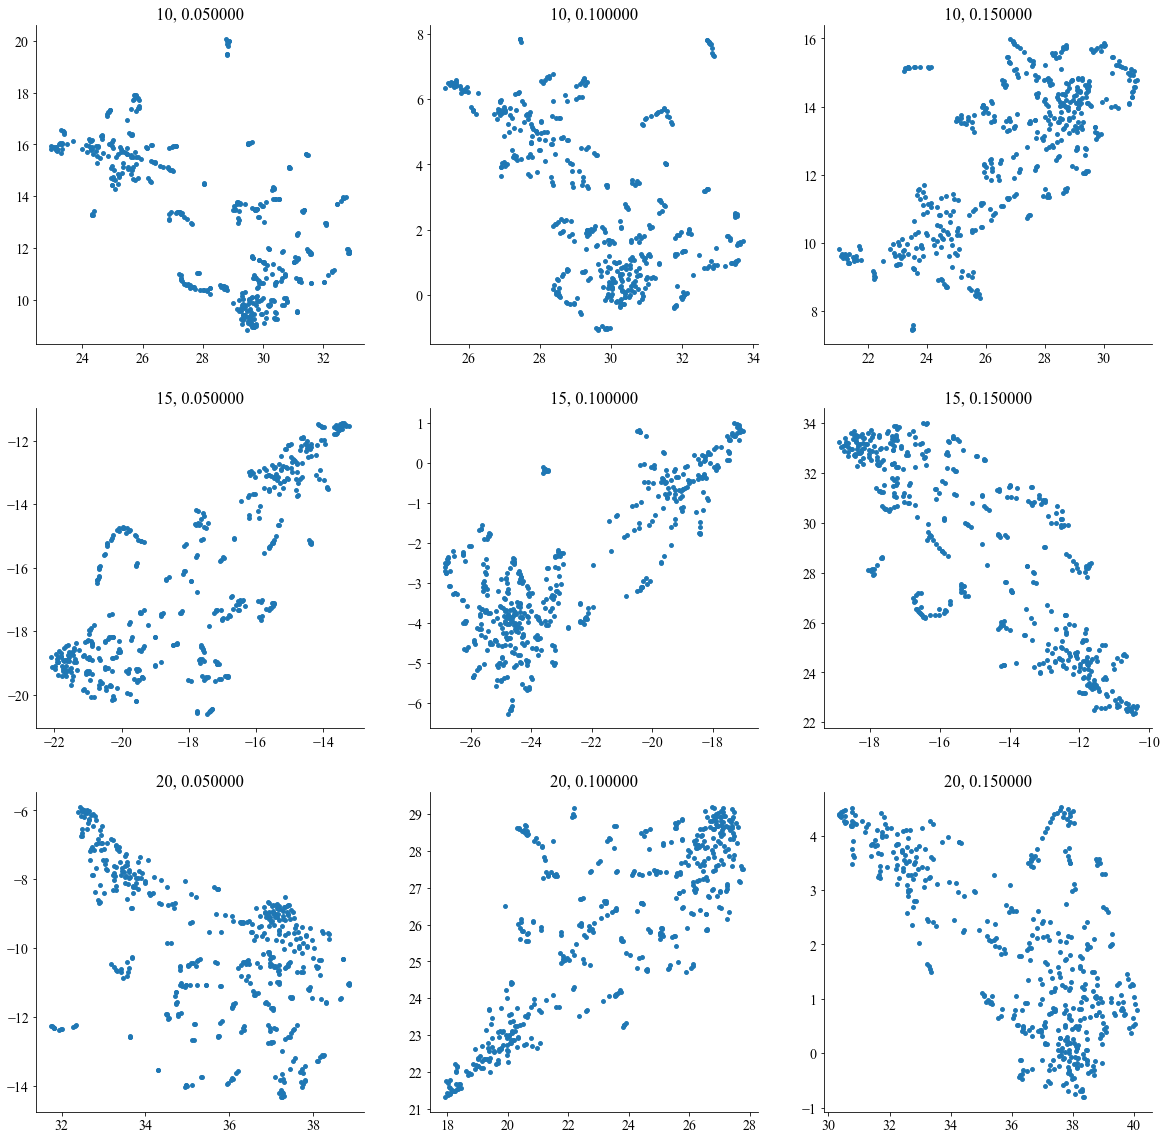

In [206]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
neighs = [10, 15, 20]
min_dists = [0.05, 0.1, 0.15]
for (i, ni), (j, nj) in product(enumerate(neighs), enumerate(min_dists)):
    reducer = umap.UMAP(n_neighbors=ni, min_dist=nj)
    Y_umap = reducer.fit_transform(scaled_spectra)
    ax[i, j].scatter(*Y_umap.T, s=15)
    ax[i, j].set_title('%d, %f' % (ni, nj))

In [17]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.05)
Y_umap = reducer.fit_transform(scaled_spectra)
results['umap_x'] = pd.Series(Y_umap[:, 0], index=results.index)
results['umap_y'] = pd.Series(Y_umap[:, 1], index=results.index)

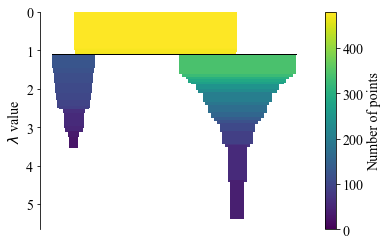

In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=10)
struct_labels = clusterer.fit_predict(Y_umap)
clusterer.condensed_tree_.plot()

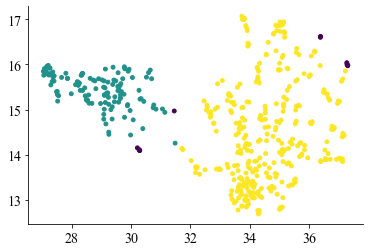

In [19]:
plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c=struct_labels, s=15)

In [20]:
results['struct_label'] = pd.Series(struct_labels, index=results.index)

In [21]:
# def plot(x, y, color, **kwargs):
#     plt.scatter(x, y, c=[color], s=15, **kwargs)
# grid = sns.FacetGrid(results, col='internal connection', row='type', hue='noise', height=4, palette=palette)
# grid.map(plot, 'umap_x', 'umap_y')
# grid.add_legend()
# grid.set_axis_labels(x_var='dimension 1', y_var='dimension 2')

# grid.savefig('images/struct_umap_noise_lvl.pdf')

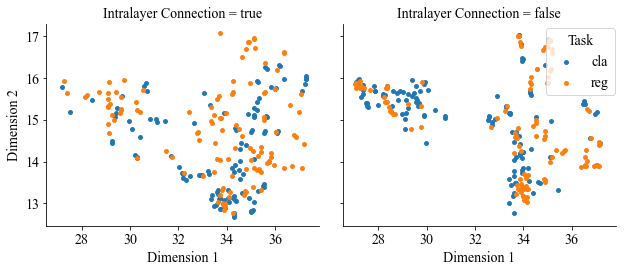

In [185]:
def plot(x, y, color, **kwargs):
    plt.scatter(x, y, c=[color], s=15, **kwargs)
grid = sns.FacetGrid(results, col='internal connection', hue='type', height=4)
grid.map(plot, 'umap_x', 'umap_y')
grid.add_legend(title='Task', loc=(0.87, 0.65), frameon=True)
grid.set_axis_labels(x_var='Dimension 1', y_var='Dimension 2')
grid.set_titles('Intralayer Connection = {col_name}')
grid.fig.tight_layout()

# grid.savefig('images/struct_umap_cla_vs_reg.pdf')

In [23]:
std_x_cla = results[(results['internal connection'] == 'true') & (results['type'] == 'cla')].umap_x
std_y_cla = results[(results['internal connection'] == 'true') & (results['type'] == 'cla')].umap_y
std_x_reg = results[(results['internal connection'] == 'true') & (results['type'] == 'reg')].umap_x
std_y_reg = results[(results['internal connection'] == 'true') & (results['type'] == 'reg')].umap_y

## Dynamics

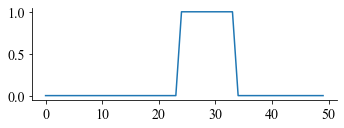

In [2]:
# Generate a random signal of 3 modes
I = np.zeros(50)
I[24:34] += 1
fig, ax = plt.subplots(1, figsize=(5, 2))
ax.plot(I)#, c='black', linewidth=3)
fig.tight_layout()
# fig.savefig('images/sig_ref.pdf')

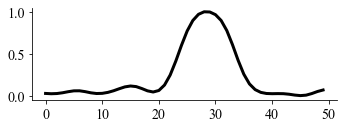

In [3]:
I += np.random.uniform(-0.2, 0.2, 50)
I = np.convolve(I, norm.pdf(np.arange(-10, 11), scale=2), 'same')
I = (I - I.min()) / (I.max() - I.min())
fig, ax = plt.subplots(1, figsize=(5, 2))
ax.plot(I, c='black', linewidth=3)
fig.tight_layout()
# fig.savefig('images/sig_per.svg')

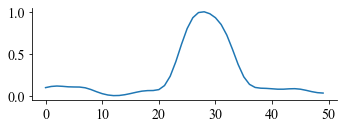

In [47]:
fig, ax = plt.subplots(1, figsize=(5, 2))
ax.plot(I)
fig.tight_layout()
# fig.savefig('images/sig_per.pdf')

(-2.45, 51.45, -0.32532781783524634, 0.704426421455842)

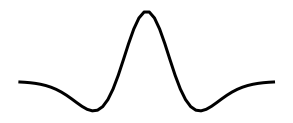

In [210]:
dog = norm.pdf(np.linspace(-1, 1), scale=0.2) - norm.pdf(np.linspace(-1, 1), scale=0.3) 
plt.figure(figsize=(5, 2))
plt.plot(dog, c='black', linewidth=3)
plt.axis('off')
# plt.savefig('images/dog.pdf')

In [124]:
def sim(n_cells, conn, th):
    tmax = 200
    states = [np.zeros((tmax, i)) for i in n_cells]

    for t in range(1, tmax):
        for i in range(len(states)):
            aux = - states[i][t-1] + 0.5

            for j in range(len(states)):
                wji = conn[j, i]
                if type(wji) is np.ndarray:
                    if len(wji.shape) == 1:
                        wji = wji[None, :] if states[j][t-1].shape[0] == 1 else wji[:, None]
                        
                    try:
                        aux += states[j][t-1] @ wji
                    except:
                        print(i, j, aux.shape, states[j][t-1].shape, wji.shape)

            if i == 0:
                aux += I
            states[i][t] = states[i][t-1] + 1 / 120 * aux
            
            if i != len(states) - 1:
                states[i][t, states[i][t] < 0] = 0
                states[i][t, states[i][t] > 1] = 1
            else:
                states[i][t, states[i][t] > th] = -th/2
    return states

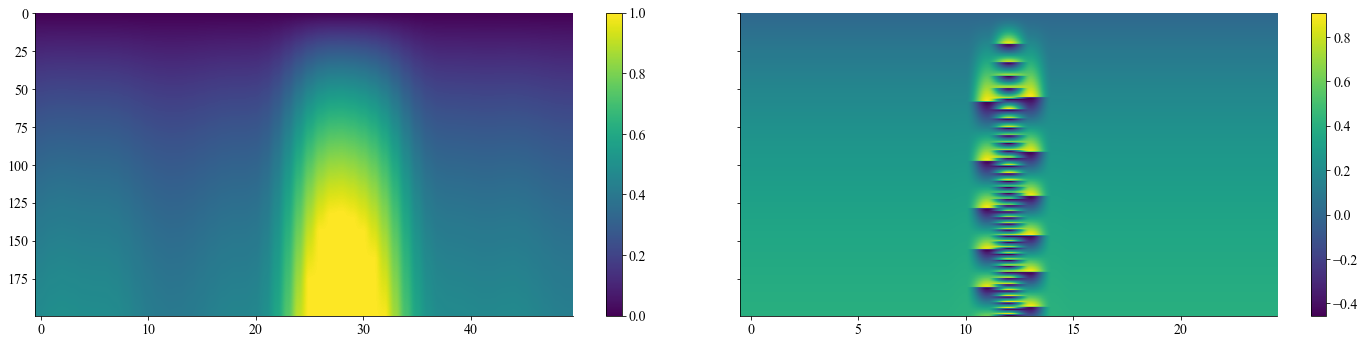

In [144]:
k = 31
n_cells = results.iloc[k].genome_types.n_cell
conn = results.iloc[k].connections
states = sim(n_cells, conn, results.iloc[k].genome_shared.ganglion_th.values[0])

fig, ax = plt.subplots(1, len(states), figsize=(20, 5), sharey='all')
fig.tight_layout()
for i in range(len(states)):
    im = ax[i].imshow(states[i], aspect='auto')
    fig.colorbar(im, ax=ax[i])

param_regressio
   n_types  ganglion_th  test_loss  n_synapses
0        2     0.912238   0.029894        1250
   n_cell      axon  dendrite  polarity       phi      beta  interval  alpha
0      50  0.604321  0.779381         1  0.655081 -0.100985   2.49710   0.02
1      25  0.179803  0.945297        -1  0.095730 -0.417089   1.42396   1.00


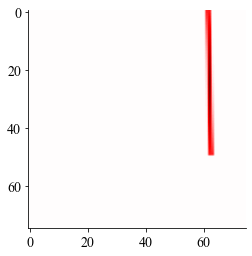

In [145]:
mini, maxi = results.iloc[k].adjacency.min(), results.iloc[k].adjacency.max()
maxi = max((abs(mini), abs(maxi)))
plt.imshow(results.iloc[k].adjacency, cmap='seismic', vmin=-maxi, vmax=maxi)
print(results.iloc[k].type)
print(results.iloc[k].genome_shared)
print(results.iloc[k].genome_types)

In [212]:
k = 0
responses = []
for _, row in results.iterrows():
    n_cells = row.genome_types.n_cell
    conn = row.connections
    states = sim(n_cells, conn)
    responses.append(expit(states[k][-1]))
    
results['receptor_responses'] = pd.Series(responses, index=results.index)

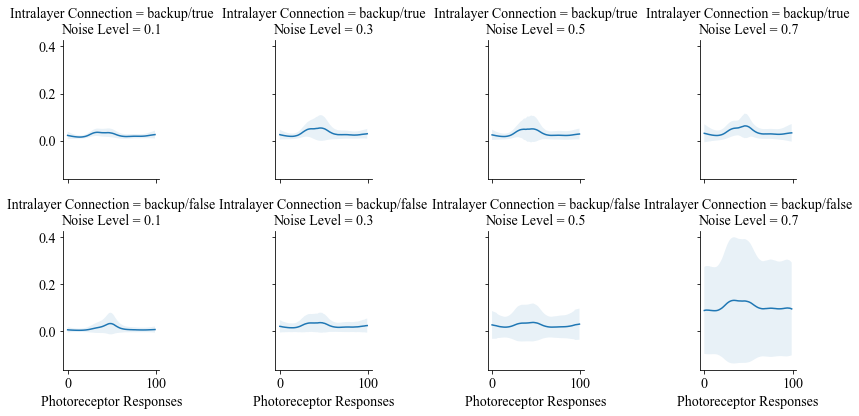

In [213]:
def plot(x, color, **kwargs):
    x = np.vstack(x.to_list())
    x_mean = x.mean(axis=0)
    x_std = x.std(axis=0)
    a = np.arange(100)
    plt.fill_between(a, x_mean - x_std, x_mean + x_std, alpha=0.1)
    plt.plot(a, x_mean)
    
grid = sns.FacetGrid(results, col='noise', row='internal connection')
grid.map(plot, 'receptor_responses')
grid.set_axis_labels(x_var='Photoreceptor Responses')
grid.set_titles('Intralayer Connection = {row_name}\nNoise Level = {col_name}')
grid.fig.tight_layout()

# grid.savefig('images/sig_response.pdf')

In [179]:
responses_int = np.vstack(results[results['internal connection'] == 'true'].receptor_responses.to_list())
responses_int = responses_int[:, list(range(24)) + list(range(57, 100))]
responses_int = responses_int.mean(axis=1)
responses_int.shape

ValueError: need at least one array to concatenate

In [36]:
responses_noi = np.vstack(results[results['internal connection'] == 'false'].receptor_responses.to_list())
responses_noi = responses_noi[:, list(range(24)) + list(range(57, 100))]
responses_noi = responses_noi.mean(axis=1)
responses_noi.shape

ValueError: need at least one array to concatenate

In [37]:
ttest_rel(responses_int, responses_noi)

NameError: name 'responses_int' is not defined

In [38]:
responses = np.vstack(results.receptor_responses.to_list())

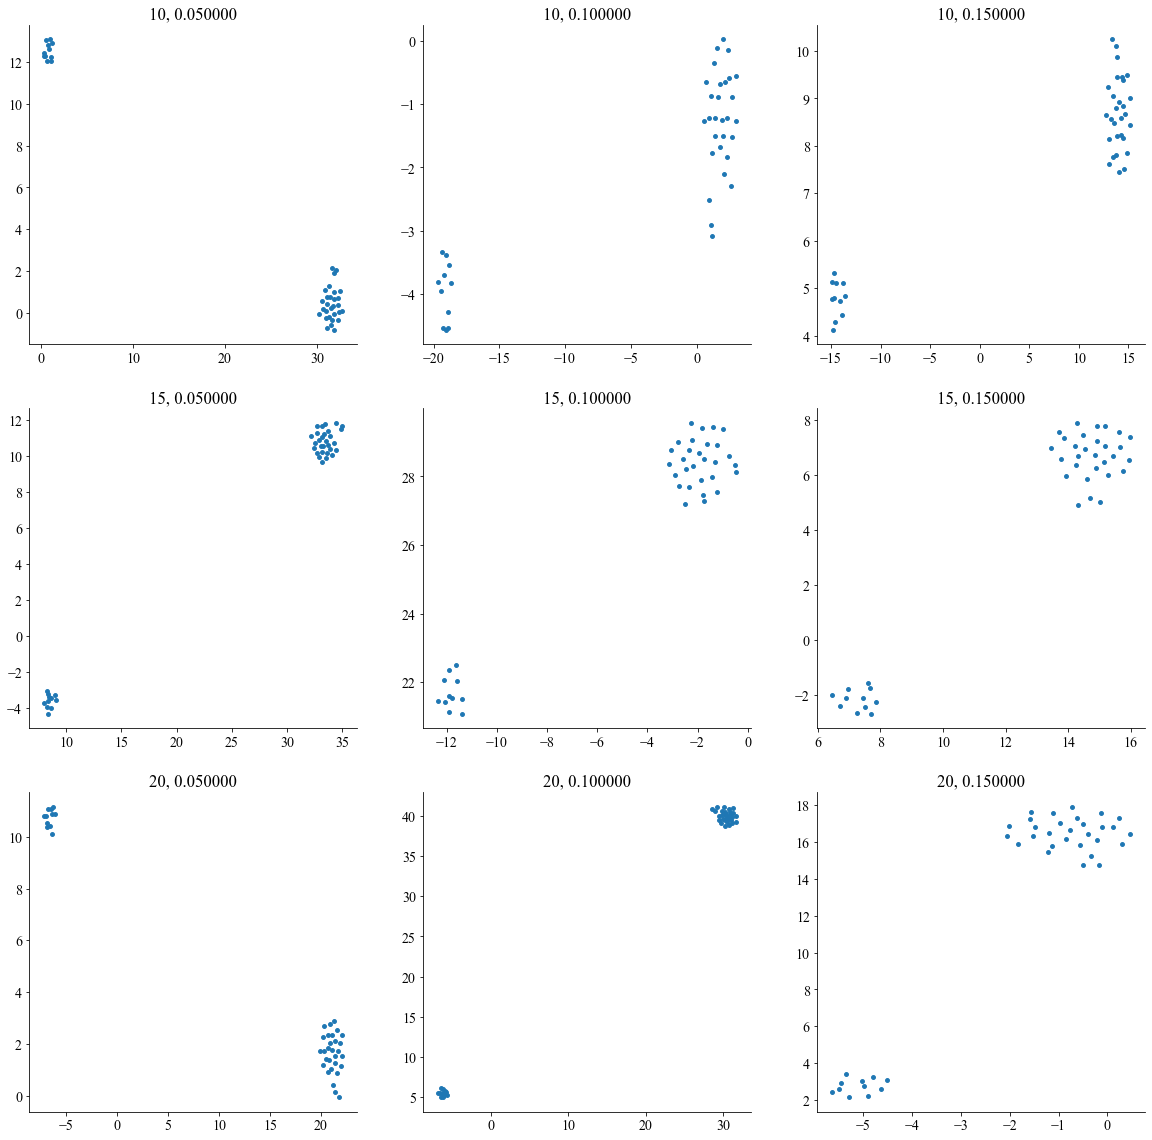

In [39]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
neighs = [10, 15, 20]
min_dists = [0.05, 0.1, 0.15]
for (i, ni), (j, nj) in product(enumerate(neighs), enumerate(min_dists)):
    reducer = umap.UMAP(n_neighbors=ni, min_dist=nj)
    Y_umap = reducer.fit_transform(responses)
    ax[i, j].scatter(*Y_umap.T, s=15)
    ax[i, j].set_title('%d, %f' % (ni, nj))

In [40]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.05)
Y_umap = reducer.fit_transform(responses)
results['responses_umap_x'] = pd.Series(Y_umap[:, 0], index=results.index)
results['responses_umap_y'] = pd.Series(Y_umap[:, 1], index=results.index)

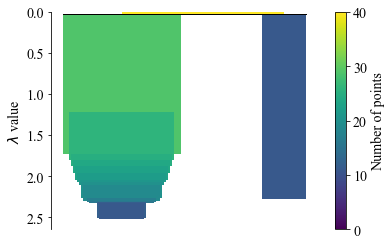

In [70]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=2)
struct_labels = clusterer.fit_predict(Y_umap)
clusterer.condensed_tree_.plot()

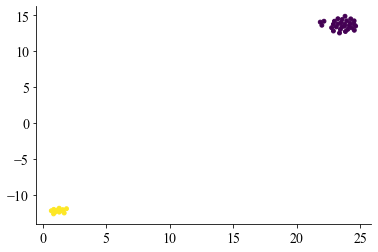

In [71]:
plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c=struct_labels, s=15)

In [72]:
results['dyn_label'] = pd.Series(struct_labels, index=results.index)

In [44]:
# def plot(x, y, color, **kwargs):
#     plt.scatter(x, y, c=[color], s=15, **kwargs)
# grid = sns.FacetGrid(results, col='internal connection', row='type', hue='noise', height=4, palette=palette)
# grid.map(plot, 'responses_umap_x', 'responses_umap_y')
# grid.add_legend()
# grid.set_axis_labels(x_var='dimension 1', y_var='dimension 2')

# grid.savefig('images/sig_response_umap_noise_lvl.pdf')

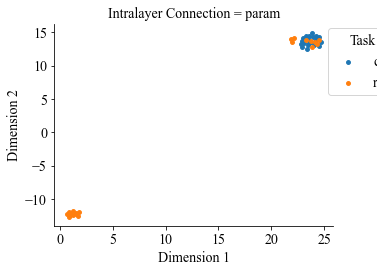

In [52]:
def plot(x, y, color, **kwargs):
    plt.scatter(x, y, c=[color], s=15, **kwargs)
grid = sns.FacetGrid(results, col='internal connection', hue='type', height=4)
grid.map(plot, 'responses_umap_x', 'responses_umap_y')
grid.add_legend(title='Task', loc=(0.87, 0.65), frameon=True)
grid.set_axis_labels(x_var='Dimension 1', y_var='Dimension 2')
grid.set_titles('Intralayer Connection = {col_name}')
grid.fig.tight_layout()

# grid.savefig('images/sig_response_umap_cla_vs_reg.pdf')

Text(0.5, 0, 'Distance')

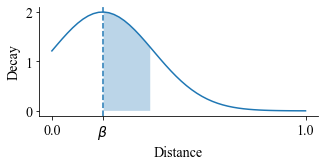

In [46]:
x = np.linspace(0, 1)
y = norm.pdf(x, scale=0.2, loc=0.2)
fig, ax = plt.subplots(1, figsize=(5, 2))
ax.plot(x, y)
ax.axvline(x=0.2, linestyle='--')
x_fill = x[(x >= 0.2) & (x <= 0.4)]
y_fill = norm.pdf(x_fill, scale=0.2, loc=0.2)
ax.fill_between(x_fill, y_fill, np.zeros(x_fill.shape), alpha=0.3)
ax.set_xticks([0.0, 0.2, 1.0])
ax.set_xticklabels([0.0, r'$\beta$', 1.0])
ax.set_ylabel('Decay')
ax.set_xlabel('Distance')

# fig.savefig('images/decay.pdf')

## Cluster Visualization

In [47]:
def plot(x, color, **kwargs):
    i = np.random.randint(0, len(x))
    plt.imshow(x.iloc[i], cmap='seismic', vmin=-1, vmax=1)
grid = sns.FacetGrid(results[results.struct_label != -1], col='struct_label', sharex=False, sharey=False, col_wrap=2)
grid.map(plot, 'adjacency')
grid.set_titles('Cluster = {col_name}')
grid.set_xlabels('')
grid.fig.tight_layout()

# grid.savefig('images/clusteradj_struct.pdf')

AttributeError: 'DataFrame' object has no attribute 'struct_label'

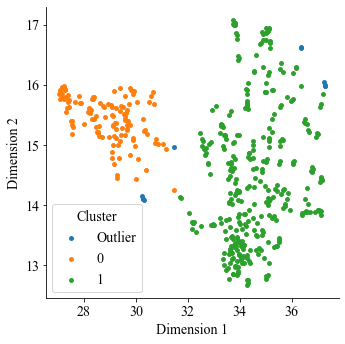

In [227]:
grid = sns.FacetGrid(results, hue='struct_label', height=5)
grid.map(plt.scatter, 'umap_x', 'umap_y', s=15)
grid.add_legend(title='Cluster', loc=(0.15, 0.15), frameon=True)
grid._legend.texts[0].set_text('Outlier')
grid.set_axis_labels(x_var='Dimension 1', y_var='Dimension 2')

# grid.savefig('images/clustervis_struct.pdf')

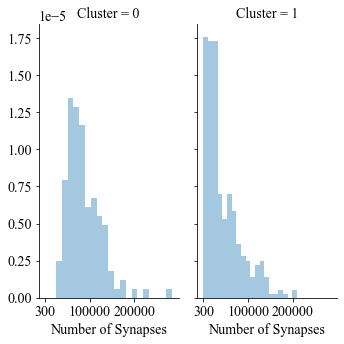

In [190]:
def plot(x, color, **kwargs):
    x = [xi.n_synapses.values[0] for xi in x]
    ax = sns.distplot(x, color=color, **kwargs)

grid = sns.FacetGrid(results[results.struct_label != -1], col='struct_label', height=5, aspect=.5)
grid.map(plot, 'genome_shared', kde=False, norm_hist=True, bins=20)
grid.set_titles('Cluster = {col_name}')
grid.set_axis_labels(x_var='Number of Synapses')
grid.set(xticks=(300, 100000, 200000))
# grid.savefig('images/struct_dist_nsyn.pdf')

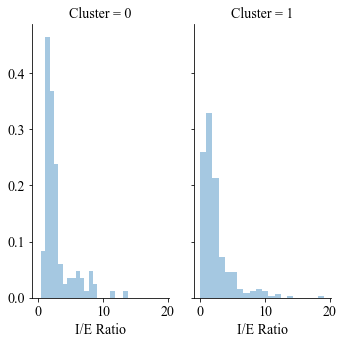

In [191]:
def plot(x, color, **kwargs):
    x = [np.sum(xi < 0) / np.sum(xi > 0) for xi in x]
    ax = sns.distplot(x, color=color, **kwargs)

grid = sns.FacetGrid(results[results.struct_label != -1], col='struct_label', height=5, aspect=.5)
grid.map(plot, 'adjacency', kde=False, norm_hist=True, bins=20)
grid.set_titles('Cluster = {col_name}')
grid.set_axis_labels(x_var='I/E Ratio')
# grid.savefig('images/struct_dist_ie.pdf')

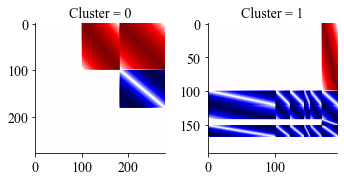

In [74]:
def plot(x, color, **kwargs):
    i = np.random.randint(0, len(x))
    plt.imshow(x.iloc[i], cmap='seismic', vmin=-1, vmax=1)
grid = sns.FacetGrid(results[results.dyn_label != -1], col='dyn_label', sharex=False, sharey=False, height=5, aspect=.5)
grid.map(plot, 'adjacency')
grid.set_titles('Cluster = {col_name}')
grid.set_xlabels('')
grid.fig.tight_layout()

# grid.savefig('images/clusteradj_dyn.pdf')

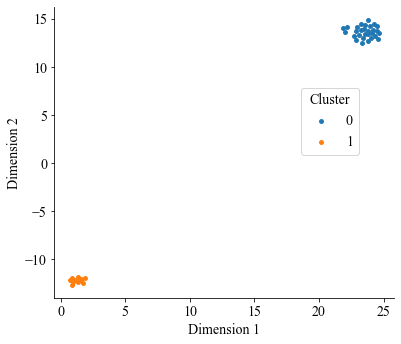

In [77]:
grid = sns.FacetGrid(results, hue='dyn_label', height=5)
grid.map(plt.scatter, 'responses_umap_x', 'responses_umap_y', s=15)
grid.add_legend(title='Cluster', loc=(0.75, 0.55), frameon=True)
# grid._legend.texts[0].set_text('Outlier')
grid.set_axis_labels(x_var='Dimension 1', y_var='Dimension 2')
grid.fig.tight_layout()

# grid.savefig('images/clustervis_dyn.pdf')

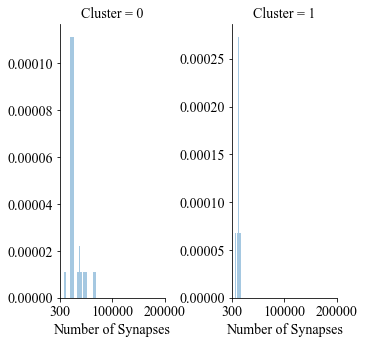

In [78]:
def plot(x, color, **kwargs):
    x = [xi.n_synapses.values[0] for xi in x]
    ax = sns.distplot(x, color=color, **kwargs)

grid = sns.FacetGrid(results[results.dyn_label != -1], col='dyn_label', height=5, aspect=.5, sharey=False)
grid.map(plot, 'genome_shared', kde=False, norm_hist=True, bins=20)
grid.set_titles('Cluster = {col_name}')
grid.set_axis_labels(x_var='Number of Synapses')
grid.set(xticks=(300, 100000, 200000))
# grid.savefig('images/dyn_dist_nsyn.pdf')

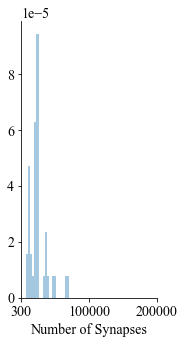

In [79]:
def plot(x, color, **kwargs):
    x = [xi.n_synapses.values[0] for xi in x]
    ax = sns.distplot(x, color=color, **kwargs)

grid = sns.FacetGrid(results[results.dyn_label != -1], height=5, aspect=.5, sharey=False)
grid.map(plot, 'genome_shared', kde=False, norm_hist=True, bins=20)
grid.set_titles('Cluster = {col_name}')
grid.set_axis_labels(x_var='Number of Synapses')
grid.set(xticks=(300, 100000, 200000))
# grid.savefig('images/dyn_dist_nsyn.pdf')

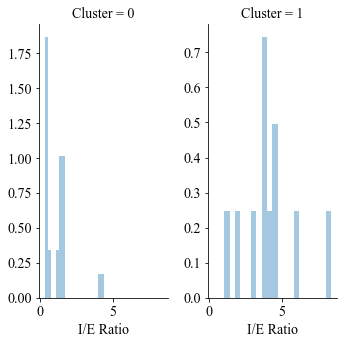

In [80]:
def plot(x, color, **kwargs):
    x = [np.sum(xi < 0) / np.sum(xi > 0) for xi in x]
    ax = sns.distplot(x, color=color, **kwargs)

grid = sns.FacetGrid(results[results.dyn_label != -1], col='dyn_label', height=5, aspect=.5, sharey=False)
grid.map(plot, 'adjacency', kde=False, norm_hist=True, bins=20)
grid.set_titles('Cluster = {col_name}')
grid.set_axis_labels(x_var='I/E Ratio')
# grid.savefig('images/dyn_dist_ie.pdf')

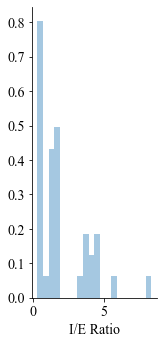

In [81]:
def plot(x, color, **kwargs):
    x = [np.sum(xi < 0) / np.sum(xi > 0) for xi in x]
    ax = sns.distplot(x, color=color, **kwargs)

grid = sns.FacetGrid(results[results.dyn_label != -1], height=5, aspect=.5, sharey=False)
grid.map(plot, 'adjacency', kde=False, norm_hist=True, bins=20)
grid.set_titles('Cluster = {col_name}')
grid.set_axis_labels(x_var='I/E Ratio')
# grid.savefig('images/dyn_dist_ie.pdf')

In [253]:
def sim(n_cells, conn, th):
    tmax = 50
    gang = np.zeros((100, n_cells.iloc[-1]))
    G = 3
    for I in range(100-G):
        states = [np.zeros((tmax, i)) for i in n_cells]
        for t in range(1, tmax):
            for i in range(len(states)):
                aux = - states[i][t-1]

                for j in range(len(states)):
                    wji = conn[j, i]
                    if type(wji) is np.ndarray:
                        if len(wji.shape) == 1:
                            wji = wji[None, :] if states[j][t-1].shape[0] == 1 else wji[:, None]

                        try:
                            aux += expit(states[j][t-1]) @ wji
                        except:
                            print(aux.shape, states[j][t-1].shape, wji.shape)

                if i == 0:
                    aux[I:I+G] += 1
                states[i][t] = states[i][t-1] + 1/10 * aux
                
                if i == len(states) - 1:
                    indices = states[i][t] > th
                    gang[I] += np.array(indices, dtype=np.int32)
                    states[i][t, indices] = 0

        gang[I] /= tmax
                    
    return gang

In [254]:
k = 0
responses = []
for _, row in results.iterrows():
    n_cells = row.genome_types.n_cell
    conn = row.connections
    gang = sim(n_cells, conn, row.genome_shared.ganglion_th.values[0])
    responses.append(gang)
    
results['gang_responses'] = pd.Series(responses, index=results.index)

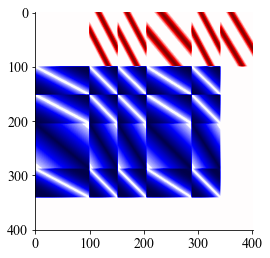

In [387]:
plt.imshow(results['adjacency'].iloc[200], cmap='seismic', vmin=-1, vmax=1)

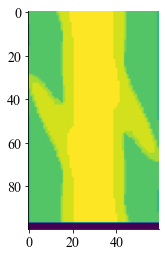

In [392]:
plt.imshow(results['gang_responses'].iloc[200])

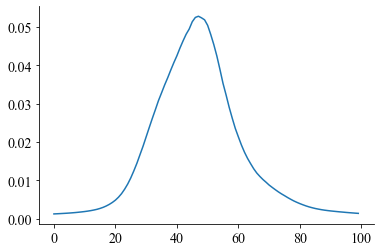

In [268]:
plt.plot(results['receptor_responses'].iloc[100])

In [388]:
tmax = 100

conn = results.iloc[200].connections
n_cells = results.iloc[200].genome_types.n_cell
states = [np.zeros((tmax, i)) for i in n_cells]

for t in range(1, tmax):
    for i in range(len(states)):
        aux = - states[i][t-1]

        for j in range(len(states)):
            wji = conn[j, i]
            if type(wji) is np.ndarray:
                if len(wji.shape) == 1:
                    wji = wji[None, :] if states[j][t-1].shape[0] == 1 else wji[:, None]

                try:
                    aux += expit(states[j][t-1] @ wji)
                except:
                    print(aux.shape, states[j][t-1].shape, wji.shape)

        if i == 0:
            aux += I
        states[i][t] = states[i][t-1] + 1/10 * aux
        if i == len(states)-1:
            states[i][t, states[i][t] > 0.5] = 0

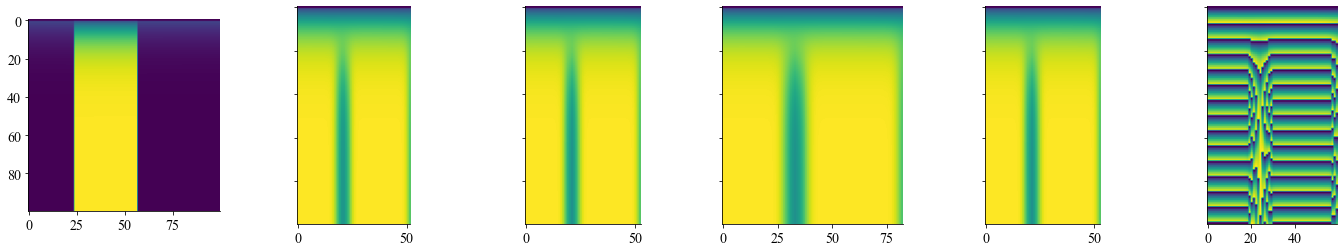

In [389]:
fig, ax = plt.subplots(1, len(states), figsize=(len(states) * 4, 4), sharey='all')
for i, s in enumerate(states):
    ax[i].imshow(s)